1. LSTM MODELİ İÇİN VERİ HAZIRLANIYOR...


/var/folders/xl/_cnln_n95bq4hsnmlbfd4_vw0000gn/T/ipykernel_54226/1944407368.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start=start_date, end=end_date, progress=False, threads=False)



2. LSTM EĞİTİMİ BAŞLIYOR...
   Epoch 10: Loss 0.06977
   Epoch 20: Loss 0.04616
   Early Stopping: Epoch 23

3. LSTM METRİKLERİ...
   • Metrikler kaydedildi: lstm_metrics.csv

4. GELECEK SİMÜLASYONU...

5. GRAFİKLER KAYDEDİLİYOR...

✓ LSTM MODELİ TAMAMLANDI.


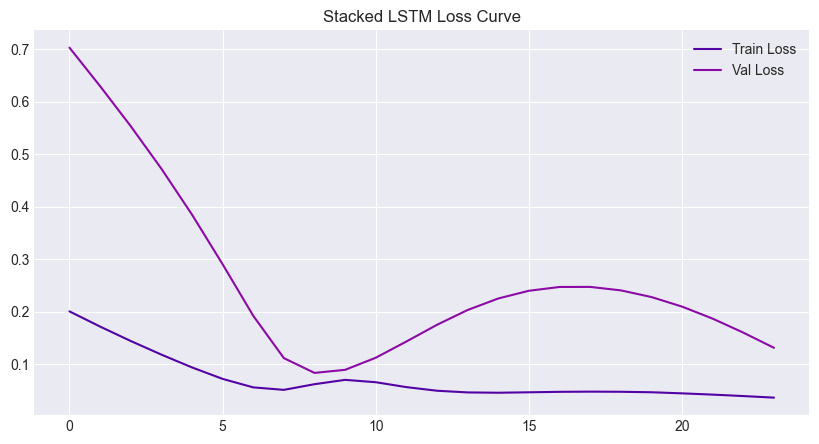

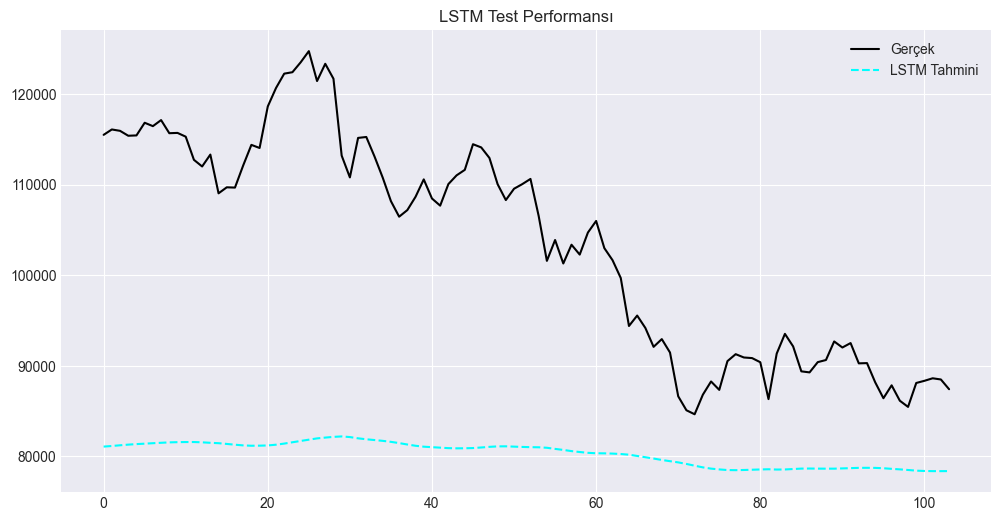

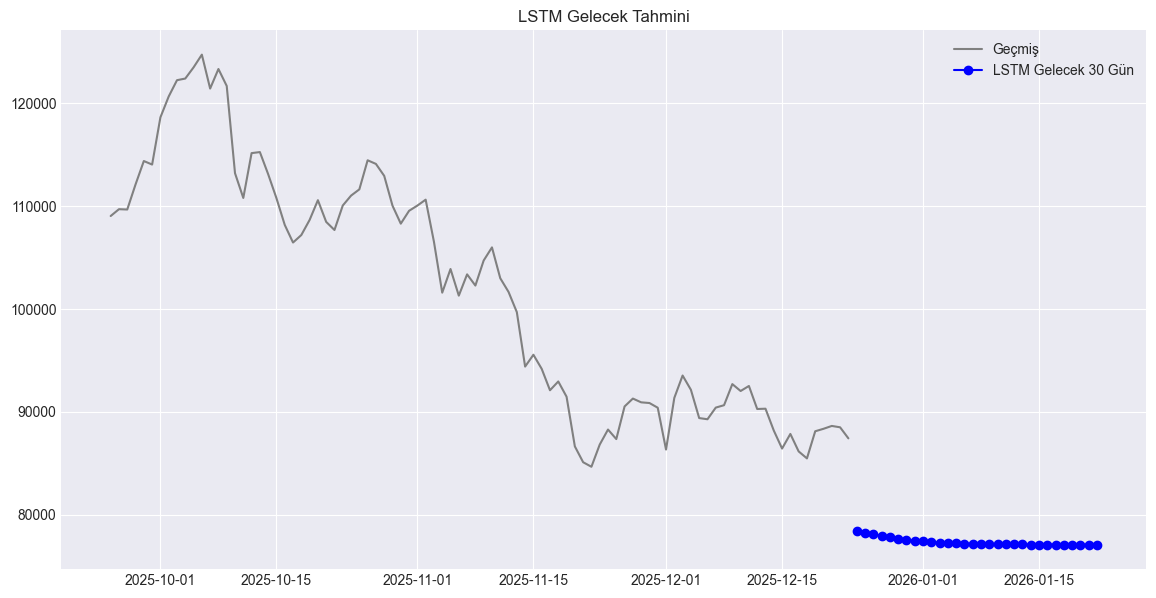

In [1]:
# =============================================================================
# MODEL 4: PYTORCH STACKED LSTM (Long Short-Term Memory)
# Final Projesi - Advanced Model 4
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from datetime import date, timedelta
import copy

# Ayarlar
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("plasma")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. VERİ HAZIRLAMA (GRU ile aynı mantık)
print("1. LSTM MODELİ İÇİN VERİ HAZIRLANIYOR...")
today = date.today()
end_date = today.strftime("%Y-%m-%d")
start_date = (today - timedelta(days=1095)).strftime("%Y-%m-%d")

try:
    df = yf.download('BTC-USD', start=start_date, end=end_date, progress=False, threads=False)
    if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
    df.reset_index(inplace=True)
except:
    df = pd.DataFrame()

data = df[['Close']].values.astype(float)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60
X, y = create_sequences(data_scaled, SEQ_LENGTH)

train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

def to_tensor(arr): return torch.from_numpy(arr).float().to(device)
X_train, y_train = to_tensor(X_train), to_tensor(y_train)
X_val, y_val = to_tensor(X_val), to_tensor(y_val)
X_test, y_test = to_tensor(X_test), to_tensor(y_test)

# 2. STACKED LSTM MODEL MİMARİSİ
class StackedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob):
        super(StackedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # LSTM Katmanı (Stacked: num_layers > 1)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# 3. EĞİTİM
print("\n2. LSTM EĞİTİMİ BAŞLIYOR...")
# LSTM genelde biraz daha fazla nöron sever
PARAMS = {'hidden_dim': 100, 'num_layers': 2, 'lr': 0.001, 'dropout': 0.2}

model = StackedLSTM(1, PARAMS['hidden_dim'], PARAMS['num_layers'], 1, PARAMS['dropout']).to(device)
optimizer = optim.Adam(model.parameters(), lr=PARAMS['lr'])
criterion = nn.MSELoss()

train_losses, val_losses = [], []
min_val_loss = float('inf')
patience, counter = 15, 0
best_wts = None

for epoch in range(150):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_out = model(X_val)
        val_loss = criterion(val_out, y_val).item()
        
    train_losses.append(loss.item())
    val_losses.append(val_loss)
    
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        counter = 0
        best_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'lstm_best.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"   Early Stopping: Epoch {epoch}")
            break
            
    if (epoch+1) % 10 == 0:
        print(f"   Epoch {epoch+1}: Loss {loss.item():.5f}")

model.load_state_dict(best_wts)

# 4. METRİKLER
print("\n3. LSTM METRİKLERİ...")
model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy()
    targets = y_test.cpu().numpy()

preds_inv = scaler.inverse_transform(preds)
targets_inv = scaler.inverse_transform(targets)

metrics = {
    "R2": r2_score(targets_inv, preds_inv),
    "RMSE": np.sqrt(mean_squared_error(targets_inv, preds_inv)),
    "MAE": mean_absolute_error(targets_inv, preds_inv),
    "MAPE": mean_absolute_percentage_error(targets_inv, preds_inv)
}
pd.DataFrame([metrics]).to_csv("lstm_metrics.csv", index=False)
print("   • Metrikler kaydedildi: lstm_metrics.csv")

# 5. GELECEK TAHMİNİ
print("\n4. GELECEK SİMÜLASYONU...")
last_sequence = data_scaled[-SEQ_LENGTH:]
current_seq = torch.from_numpy(last_sequence).float().to(device).unsqueeze(0)

future_preds = []
for _ in range(30):
    with torch.no_grad():
        pred = model(current_seq)
        future_preds.append(pred.item())
        new_pred = pred.unsqueeze(1)
        current_seq = torch.cat((current_seq[:, 1:, :], new_pred), dim=1)

future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

last_date_obj = pd.to_datetime(df['Date'].iloc[-1])
future_dates = [last_date_obj + timedelta(days=x) for x in range(1, 31)]
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecast': future_preds_inv.flatten()})
forecast_df.to_csv('lstm_future_predictions.csv', index=False)

# 6. GÖRSELLEŞTİRME
print("\n5. GRAFİKLER KAYDEDİLİYOR...")

# Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Stacked LSTM Loss Curve')
plt.legend()
plt.savefig('lstm_1_loss_curve.png')

# Test Prediction
plt.figure(figsize=(12, 6))
plt.plot(targets_inv, label='Gerçek', color='black')
plt.plot(preds_inv, label='LSTM Tahmini', color='cyan', linestyle='--')
plt.title('LSTM Test Performansı')
plt.legend()
plt.savefig('lstm_2_test_prediction.png')

# Future
plt.figure(figsize=(14, 7))
hist_df = df.iloc[-90:]
plt.plot(hist_df['Date'], hist_df['Close'], label='Geçmiş', color='gray')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='LSTM Gelecek 30 Gün', color='blue', marker='o')
plt.title('LSTM Gelecek Tahmini')
plt.legend()
plt.savefig('lstm_3_future_forecast.png')

print("\n✓ LSTM MODELİ TAMAMLANDI.")